# Decision Tree Surrogate Demo
***

## 0.) Define DTSurrogateExplainer class

In [14]:
import os
import re
import subprocess
from subprocess import CalledProcessError
import time
from h2o.estimators.gbm import H2OGradientBoostingEstimator


class DTSurrogateExplainer(object):

    """ Simple python wrapper of H2O PrintMojo Java class geared toward 
    generating single decision tree surrogate models.
    
    References:
    
    * http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
    * https://github.com/h2oai/h2o-3/blob/master/h2o-genmodel/src/main/java/hex/genmodel/tools/PrintMojo.java
    
    License:
    
    Copyright (c) 2017 by h2o.ai

    Licensed under the Apache License, Version 2.0 (the "License");
    you may not use this file except in compliance with the License.
    You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

    Unless required by applicable law or agreed to in writing, software
    distributed under the License is distributed on an "AS IS" BASIS,
    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
    See the License for the specific language governing permissions and
    limitations under the License.
    
    """

    def __init__(self, h2o_jar_path=None, seed=None, preserve_files=None,
                 max_depth=None, details=None, jupyter_display=None):

        """ Constructor.
        
        :param h2o_jar_path: Mandatory string that contains the location of 
        h2o.jar.
        :param seed: Integer random seed for increasing reproducibility, 
        default 12345.
        :param preserve_files: Boolean for whether to preserve graphviz 
        and MOJO representations of the surrogate model in working directory, 
        default False.
        :param max_depth: Integer maximum depth of decision tree surrogate 
        model. Recommended <= 5, default 3.
        :param details: Boolean for whether to print details on surrogate model 
        PNG, default False.
        :param jupyter_display: Boolean for whether to attempt to display 
        generated surrogate model in a Jupyter notebook, default False.
        
        """

        # instance attributes

        # for consistent names that help prevent overwriting past results
        self.time_stamp = None

        # stores MOJO path for use between train and explain methods
        self.mojo_path = None

        # MANDATORY argument that locates h2o jar path
        # TODO look for this somewhere else ... must be somewhere in py module
        self.h2o_jar_path = h2o_jar_path

        # set defaults for instance attributes

        if seed is None:
            self.seed = 12345
        else:
            self.seed = seed

        if preserve_files is None:
            self.preserve_files = False
        else:
            self.preserve_files = preserve_files

        if max_depth is None:
            self.max_depth = 3
        else:
            self.max_depth = max_depth

        if details is None:
            self.details = False
        else:
            self.details = details

        if jupyter_display is None:
            self.jupyter_display = False
        else:
            self.jupyter_display = jupyter_display

    def train(self, training_frame=None, x=None, yhat=None):

        """ Trains a single decision tree surrogate model on the inputs of a 
        machine learning model and the predictions of a machine learning model. 
        Saves the MOJO representation of the tree to the working directory.
        
        :param training_frame: H2OFrame containing yhat and x.
        :param x: List of string inputs names for training the surrogate model. 
        These inputs should be the inputs used in the original ML model to be 
        explained.
        :param yhat: String name of variable created by ML model, i.e. the 
        predicted variable to be explained by the surrogate model.
        :return: An H2OGradientBoostingEstimator object representing the 
        surrogate model.
        
        """

        # create time stamp for model id and MOJO
        self.time_stamp = re.sub('[: ]', '_', time.asctime())
        model_id = 'dt_surrogate_' + self.time_stamp

        # train single tree surrogate model
        surrogate = H2OGradientBoostingEstimator(ntrees=1,
                                                 sample_rate=1,
                                                 col_sample_rate=1,
                                                 max_depth=self.max_depth,
                                                 model_id=model_id)

        _ = surrogate.train(x=x, y=yhat, training_frame=training_frame)

        # persist MOJO
        # from which to generate plot of surrogate
        self.mojo_path = surrogate.download_mojo(path='.')

        return surrogate

    def explain(self):

        """ Uses H2O PrintMojo Java class to create a time-stamped graohviz and
        PNG representation of the surrogate model MOJO created by train in the 
        working directory. Optionally displays the PNG in a Jupyter notebook 
        and optionally preserves the MOJO created by train and the graphviz 
        representation created here.   
    
        """

        # create time stamp for .gv and .png
        model_id = 'dt_surrogate_' + self.time_stamp

        # generate graphviz representation of decision tree surrogate

        gv_file_name = model_id + '.gv'
        gv_args = str('-cp ' + self.h2o_jar_path +
                      ' hex.genmodel.tools.PrintMojo --tree 0 -i '
                      + self.mojo_path + ' -o').split()
        gv_args.insert(0, 'java')
        gv_args.append(gv_file_name)
        if self.details:
            gv_args.append('--detail')

        try:
            subprocess.call(gv_args)
        except IOError as ioe:
            print("I/O error({0}): {1}".format(ioe.errno, ioe.strerror))
        except CalledProcessError as cpe:
            print('Subprocess error: ', cpe.output())

        # generate PNG of decision tree surrogate

        png_file_name = model_id + '.png'
        png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
        png_args = png_args.split()

        try:
            subprocess.call(png_args)
        except IOError as ioe:
            print("I/O error({0}): {1}".format(ioe.errno, ioe.strerror))
        except CalledProcessError as cpe:
            print('Subprocess error: ', cpe.output())

        # display
        if self.jupyter_display:
            from IPython.display import Image
            from IPython.display import display
            display(Image((png_file_name)))

        # housekeeping
        if not self.preserve_files:
            os.remove(self.mojo_path)
            os.remove(gv_file_name)


## 1.) Preliminaries: imports, start H2O, load data

In [2]:
# imports
import h2o
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

In [3]:
# start and connect to h2o server
h2o.init(max_mem_size='12G')

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmp_s89h33w
  JVM stdout: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmp_s89h33w/h2o_phall_started_from_python.out
  JVM stderr: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmp_s89h33w/h2o_phall_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster version:,3.10.4.3
H2O cluster version age:,18 days
H2O cluster name:,H2O_from_python_phall_56o3al
H2O cluster total nodes:,1
H2O cluster free memory:,10.67 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [4]:
# load clean data
path = 'https://raw.githubusercontent.com/h2oai/app-consumer-loan/master/data/loan.csv'

In [5]:
# define input variable measurement levels 
# strings automatically parsed as enums (nominal)
# numbers automatically parsed as numeric
col_types = {'bad_loan': 'enum'}
frame = h2o.import_file(path=path, col_types=col_types) # import from url

Parse progress: |█████████████████████████████████████████████████████████| 100%


## 2.) Clean and prepare data for modeling

In [6]:
# assign target and inputs
y = 'bad_loan'
X = [name for name in frame.columns if name not in [y, 'ID']]

In [7]:
# determine column types
# impute
reals, enums = [], []
for key, val in frame.types.items():
    if key in X:
        if val == 'enum':
            enums.append(key)
        else: 
            reals.append(key)
            
frame[reals].impute(method='median')
frame[enums].impute(method='mode')

[1.0, 0.0, 4.0, 1.0, 2.0]

In [8]:
# split into 40% training, 30% validation, and 30% test
train, valid, test = frame.split_frame([0.4, 0.3])

## 3.) Train a "black box" model 

In [9]:
# initialize pre-tuned nn model
nn_model = H2ODeepLearningEstimator(
    epochs=50,                    # read over the data 50 times, but in mini-batches
    hidden=[170, 320],            # 100 hidden units in 1 hidden layer
    activation='Tanh',            # bounded activation function that allows for dropout, tanh  
    l2=0.007,                     # L2 penalty can increase stability in presence of highly correlated inputs
    adaptive_rate=True,           # adjust magnitude of weight updates automatically (+stability, +accuracy)
    stopping_rounds=2,            # stop after validation error does not decrease for 5 iterations
    score_each_iteration=True,    # score validation error on every iteration
    model_id='nn_model',          # for easy lookup in flow
    seed=12345)                   
    
# train nn model
nn_model.train(
    x=X,
    y=y,
    training_frame=train,
    validation_frame=valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [10]:
# measure nn AUC
print(nn_model.auc(train=True))
print(nn_model.auc(valid=True))
print(nn_model.model_performance(test_data=test).auc())

0.6975815486563579
0.6966980881705461
0.6963366223635096


## 4.) Use a decision tree surrogate to generate explanations of the "black box" model

#### First bind the "black box" model predictions onto the training frame

In [11]:
# cbind predictions to training frame
# give them a nice name
prob_of_default = nn_model.predict(frame)
prob_of_default.columns = ['predict_default', 'p0', 'prob_of_default']
frame_yhat = frame.cbind(prob_of_default)

deeplearning prediction progress: |███████████████████████████████████████| 100%


#### Initialize DTSurrogateExplainer

In [17]:
h2o_jar_path = '/Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar'
explainer = DTSurrogateExplainer(h2o_jar_path=h2o_jar_path, jupyter_display=True)

#### Train DTSurrogateExplainer
* This builds a single, shallow decision tree
* The target of the decision tree is the predictions of the black box model
* The inputs of the decision tree are the original inputs to the black box model

In [18]:
yhat = 'prob_of_default'
surrogate = explainer.train(x=X, yhat=yhat, training_frame=frame_yhat)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


#### Use DTSurrogateExplainer to generate global plot of complex model

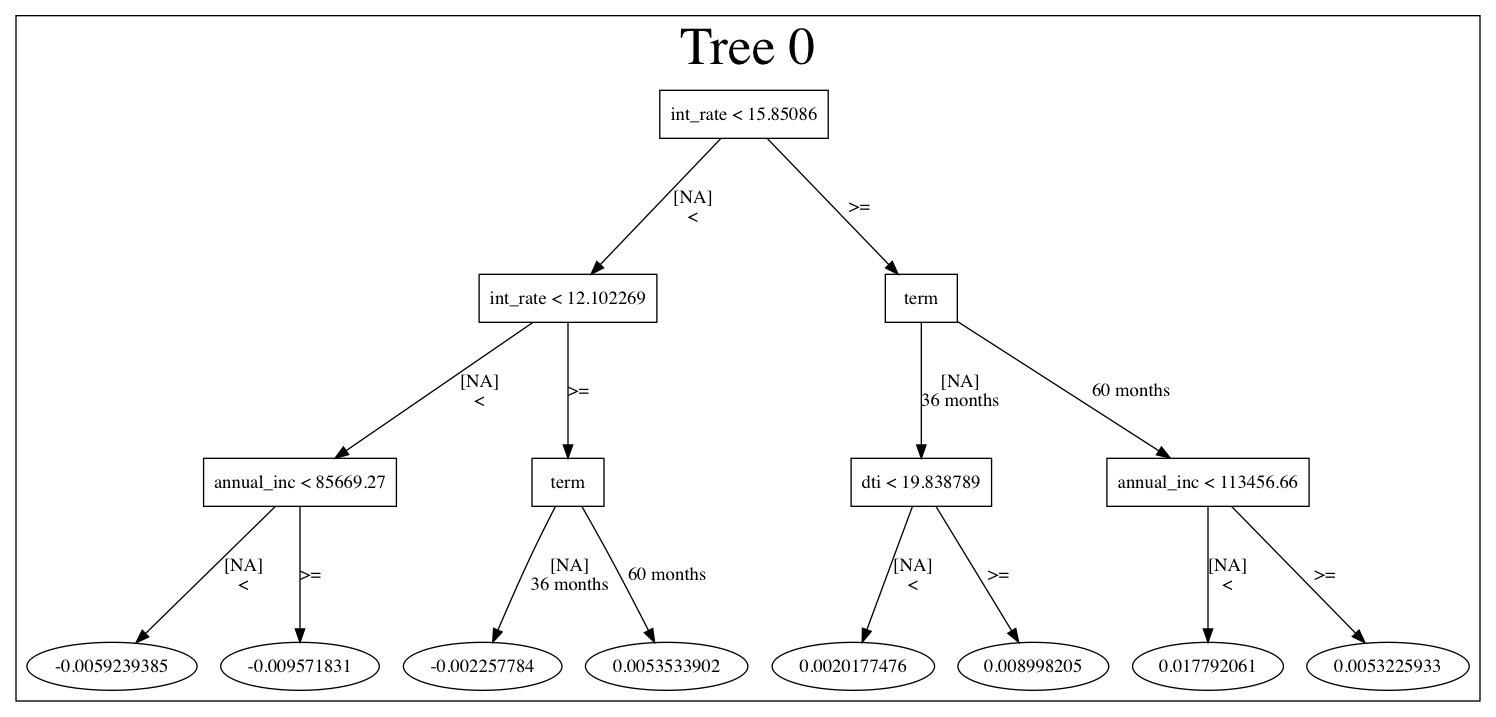

In [16]:
explainer.explain()

#### From this surrogate model we can see ...
* That interest rate, loan term and annual income are the most important variables
* Important interactions between interest rate, loan term and annual income
* The most likely customers to default on their loan (greatest probability of default) have:
  * annual incomes less than 113456
  * 60 month loan terms
* The most likely customer to pay off their loan (smallest probability of default) have:
  * interest rate less than 12.1
  * annual incomes of greater than 85669

In [14]:
# shutdown h2o
h2o.cluster().shutdown()

H2O session _sid_9868 closed.
